In [4]:
import numpy as np
import cupy as cp
import dxchange
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar

from holotomo.tomo import R
from holotomo.holo import G
from holotomo.magnification import M
from holotomo.shift import S

%matplotlib inline

cp.cuda.Device(0).use()
np.random.seed(10)

# Init data sizes and parametes of the PXM of ID16A

In [5]:
n = 256  # object size in each dimension
ntheta = 180  # number of angles (rotations)

center = n/2  # rotation axis
theta = np.linspace(0, np.pi, ntheta).astype('float32')  # projection angles

# ID16a setup
ndist = 4

detector_pixelsize = 3e-6
energy = 17.05 #[keV] xray energy
wavelength = 1.2398419840550367e-09/energy  # [m] wave length

focusToDetectorDistance = 1.208 # [m]
sx0 = -2.493e-3
z1 = np.array([1.5335e-3,1.7065e-3,2.3975e-3,3.8320e-3])[:ndist]-sx0
z2 = focusToDetectorDistance-z1
distances = (z1*z2)/focusToDetectorDistance
magnifications = focusToDetectorDistance/z1
voxelsize = detector_pixelsize/magnifications[0]*2048/n  # object voxel size

norm_magnifications = magnifications/magnifications[0]
# scaled propagation distances due to magnified probes
distances = distances*norm_magnifications**2

z1p = z1[0]  # positions of the probe for reconstruction
z2p = z1-np.tile(z1p, len(z1))
# magnification when propagating from the probe plane to the detector
magnifications2 = (z1p+z2p)/z1p
# propagation distances after switching from the point source wave to plane wave,
distances2 = (z1p*z2p)/(z1p+z2p)
norm_magnifications2 = magnifications2/magnifications2[0]/(z1p/z1[0])  # normalized magnifications
# scaled propagation distances due to magnified probes
distances2 = distances2*norm_magnifications2**2
distances2 = distances2*(z1p/z1)**2

# allow padding if there are shifts of the probe
pad = n//16
# sample size after demagnification
ne = int(np.ceil((n+2*pad)/norm_magnifications[-1]/8))*8 # make multiple of 8


## Read real and imaginary parts of the refractive index u = delta+i beta

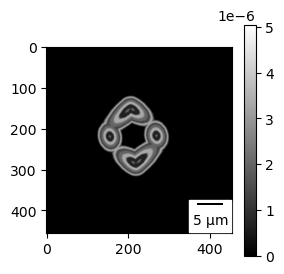

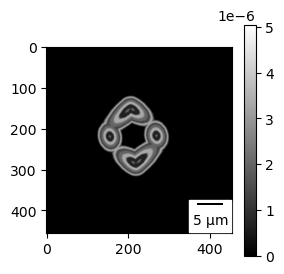

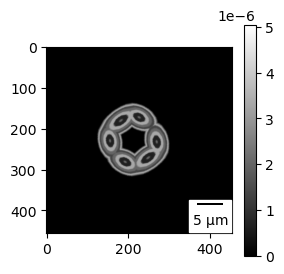

In [6]:
from scipy import ndimage

cube_all = np.zeros([ne,ne,ne],dtype='float32')
rr = (np.ones(8)*408*0.2).astype(np.int32)
amps = [3, 2, -3, 1, 2,-4,2]#, -2, -4, 5 ]
dil = [30, 28, 25, 21, 16,10,3]#, 6, 3,1]
for kk in range(len(amps)):
    cube = np.zeros([ne,ne,ne],dtype='bool')
    r = rr[kk]
    p1 = ne//2-r//2
    p2 = ne//2+r//2
    for k in range(3):    
        cube = cube.swapaxes(0,k)
        cube[p1:p2,p1,p1] = True
        cube[p1:p2,p1,p2] = True
        cube[p1:p2,p2,p1] = True
        cube[p1:p2,p2,p2] = True        
        #cube[p1:p2,p2,p2] = True        
        
    [x,y,z] = np.meshgrid(np.arange(-ne//2,ne//2),np.arange(-ne//2,ne//2),np.arange(-ne//2,ne//2))
    circ = (x**2+y**2+z**2)<dil[kk]**2        
    fcirc = np.fft.fftshift(np.fft.fftn(np.fft.fftshift(circ)))
    fcube = np.fft.fftshift(np.fft.fftn(np.fft.fftshift(cube.astype('float32'))))
    cube = np.fft.fftshift(np.fft.ifftn(np.fft.fftshift(fcube*fcirc))).real
    cube = cube>1
    cube_all+=amps[kk]*cube

cube_all = ndimage.rotate(cube_all,52,axes=(1,2),reshape=False,order=3)
cube_all = ndimage.rotate(cube_all,38,axes=(0,1),reshape=False,order=3)
cube_all = ndimage.rotate(cube_all,10,axes=(0,2),reshape=False,order=3)
cube_all[cube_all<0] = 0



u0 = (-1*cube_all*1e-6+1j*cube_all*1e-8)/1.5
u0=np.roll(u0,-15,axis=2)
u0=np.roll(u0,-10,axis=1)
v = np.arange(-ne//2,ne//2)/ne
[vx,vy,vz] = np.meshgrid(v,v,v)
v = np.exp(-10*(vx**2+vy**2+vz**2))
fu = np.fft.fftshift(np.fft.fftn(np.fft.fftshift(u0)))
u0 = np.fft.fftshift(np.fft.ifftn(np.fft.fftshift(fu*v))).astype('complex64')

fig, ax = plt.subplots(1, figsize=(3, 3))
plt.imshow(-u0[ne//2].real,cmap='gray',vmax=2.526992e-06*2,vmin=0)
plt.colorbar()
ax.add_artist(ScaleBar(voxelsize,location='lower right'))
plt.show()

fig, ax = plt.subplots(1, figsize=(3, 3))
plt.imshow(-u0[ne//2].real,cmap='gray',vmax=2.526992e-06*2,vmin=0)
plt.colorbar()
ax.add_artist(ScaleBar(voxelsize,location='lower right'))
plt.show()

fig, ax = plt.subplots(1, figsize=(3, 3))
plt.imshow(-u0[:,ne//2-8].real,cmap='gray',vmax=2.526992e-06*2,vmin=0)
plt.colorbar()
ax.add_artist(ScaleBar(voxelsize,location='lower right'))
plt.show()


np.save('data/u',u0)

u = np.load('data/u.npy')


## Compute tomographic projection data via the Fourier based method, $\mathcal{R}u$:

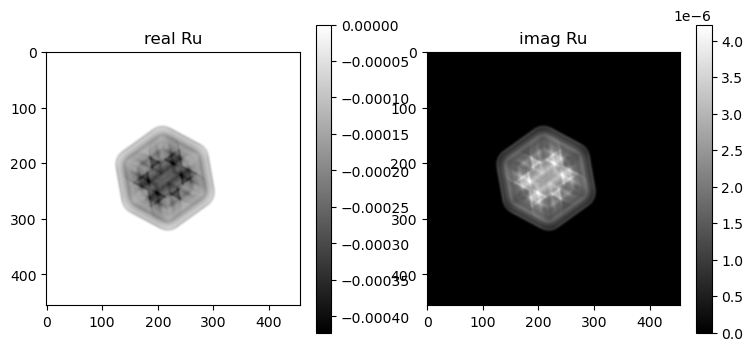

In [7]:
Ru = R(u,theta,center*ne/n)*np.sqrt(ne*ntheta) # note, operator R is designed as scaled. 
Ru = Ru.swapaxes(0,1)
fig, axs = plt.subplots(1, 2, figsize=(9, 4))
im=axs[0].imshow(np.real(Ru[0]),cmap='gray')
axs[0].set_title('real Ru')
fig.colorbar(im)
im=axs[1].imshow(np.imag(Ru[0]),cmap='gray')
axs[1].set_title('imag Ru')
fig.colorbar(im)

## Convert it to the transmittance function $e^{\frac{2\pi j}{\lambda} \mathcal{R} u }$

In [8]:
psi = np.exp(2*np.pi*1j/wavelength*voxelsize*Ru)

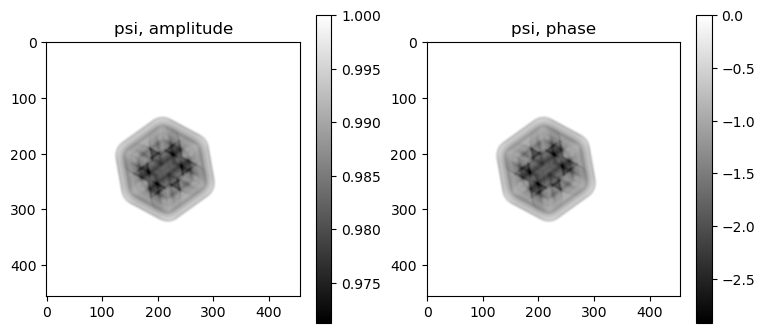

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(9, 4))
im=axs[0].imshow(np.abs(psi[0]),cmap='gray')
axs[0].set_title('psi, amplitude')
fig.colorbar(im)
im=axs[1].imshow(np.angle(psi[0]),cmap='gray')
axs[1].set_title('psi, phase')
fig.colorbar(im)

## Read a reference image previously recovered by the NFP (Near-field ptychogarphy) method at ID16A. 

In [10]:
prb_abs = dxchange.read_tiff(f'../data/prb_id16a/prb_abs_{2048}.tiff')[0:1]
prb_phase = dxchange.read_tiff(f'../data/prb_id16a/prb_phase_{2048}.tiff')[0:1]
prb = prb_abs*np.exp(1j*prb_phase).astype('complex64')  


for k in range(2):
    prb = prb[:,::2]+prb[:,1::2]
    prb = prb[:,:,::2]+prb[:,:,1::2]/4

prb = prb[:,128-pad:-128+pad,128-pad:-128+pad]
prb/=np.mean(np.abs(prb))
# prb[:]=1

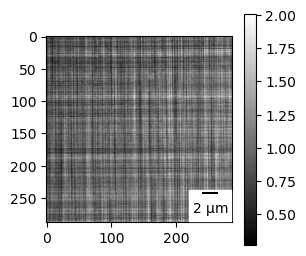

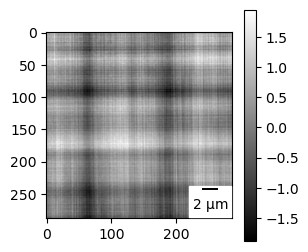

In [11]:
fig, ax = plt.subplots(1, figsize=(3, 3))
plt.imshow(np.abs(prb[0]),cmap='gray')
ax.add_artist(ScaleBar(voxelsize,location='lower right'))
plt.colorbar()
fig, ax = plt.subplots(1, figsize=(3, 3))
plt.imshow(np.angle(prb[0]),cmap='gray')
ax.add_artist(ScaleBar(voxelsize,location='lower right'))
plt.colorbar()

prb0 = prb.copy()

# Smooth the probe, the loaded one is too noisy

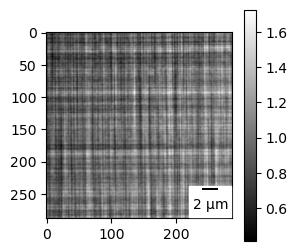

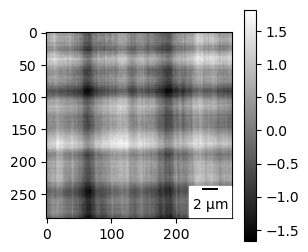

In [12]:
v = np.arange(-(n+2*pad)//2,(n+2*pad)//2)/(n+2*pad)
[vx,vy] = np.meshgrid(v,v)
v=np.exp(-10*(vx**2+vy**2))
prb = np.fft.fftshift(np.fft.fftn(np.fft.fftshift(prb0)))
prb = np.fft.fftshift(np.fft.ifftn(np.fft.fftshift(prb*v)))
prb = prb.astype('complex64')

fig, ax = plt.subplots(1, figsize=(3, 3))
plt.imshow(np.abs(prb[0]),cmap='gray')
ax.add_artist(ScaleBar(voxelsize,location='lower right'))
plt.colorbar()
fig, ax = plt.subplots(1, figsize=(3, 3))
plt.imshow(np.angle(prb[0]),cmap='gray')
ax.add_artist(ScaleBar(voxelsize,location='lower right'))
plt.colorbar()

# Random sample shifts (after magnification)

In [13]:
shifts_sample = (np.random.random([ntheta, ndist, 2]).astype('float32')-0.5)*n/32
shifts_ref = (np.random.random([ntheta, ndist, 2]).astype('float32')-0.5)*n/256# typically small

# Shifts of the probe (typically small)

In [14]:
shifts_ref0 = (np.random.random([1,ndist,2]).astype('float32')-0.5)*n/256

# Compute holographic projections for all angles and all distances
### d = $\left|\mathcal{G}_{z_j}\left((\mathcal{G}_{z_j'}\mathcal{S}_{s'_{j}}q)\mathcal{M}_j\mathcal{S}_{s_{j}}\psi\right)\right|_2^2$

In [15]:
from holotomo.chunking import gpu_batch

@gpu_batch
def fwd_holo(psi, shifts_ref, shifts_sample, prb):
    # print(prb.shape)
    prb = cp.array(prb)
    
    data = cp.zeros([psi.shape[0],ndist,n,n],dtype='complex64')
    for i in range(ndist):        
        #data[i] = fwd_holo_1dist(psi, shifts_ref[i], shifts_sample[i]/norm_magnifications[i], prb, i)
        # ill shift for each acquisition
        prbr = cp.tile(prb,[psi.shape[0],1,1])
        
        prbr = S(prbr, shifts_ref[:,i])    
        # propagate illumination
        prbr = G(prbr, wavelength, voxelsize, distances2[i])
        # object shift for each acquisition
        psir = S(psi, shifts_sample[:,i]/norm_magnifications[i])      
        
        # scale object        
        if ne != n:
            psir = M(psir, norm_magnifications[i]*ne/(n+2*pad), n+2*pad)                
        
        # multiply the ill and object
        psir *= prbr

        # propagate both
        psir = G(psir, wavelength, voxelsize, distances[i])   
        data[:,i] = psir[:,pad:n+pad,pad:n+pad]
    return data

@gpu_batch
def _fwd_holo0(prb, shifts_ref0):    
    data = cp.zeros([1,ndist, n, n], dtype='complex64')
    for j in range(ndist):
        # ill shift for each acquisition
        prbr = S(prb, shifts_ref0[:,j])                 
        # propagate illumination 
        data[:,j]=G(prbr, wavelength, voxelsize, distances[0])[:,pad:n+pad,pad:n+pad]        
    return data

def fwd_holo0(prb): 
    return _fwd_holo0(prb, shifts_ref0)

# print(prb.shape)
fpsi = fwd_holo(psi,shifts_ref,shifts_sample,prb)
fref = fwd_holo0(prb)

## Take squared absolute value to simulate data on the detector and a reference image

In [16]:
data = np.abs(fpsi)**2
ref = np.abs(fref)**2

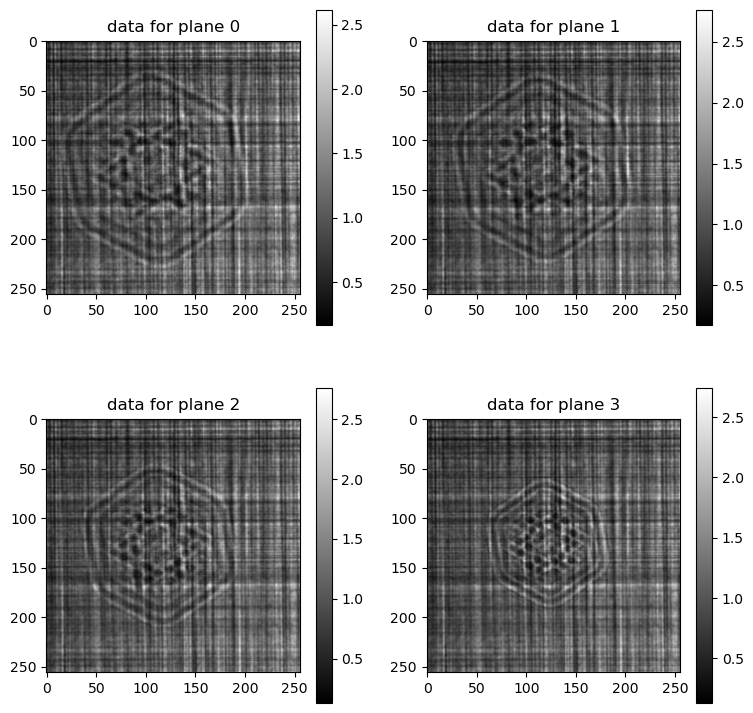

In [17]:
fig, axs = plt.subplots(2, 2, figsize=(9, 9))
im=axs[0,0].imshow(data[0,0],cmap='gray')
axs[0,0].set_title('data for plane 0')
fig.colorbar(im)
im=axs[0,1].imshow(data[0,1],cmap='gray')
axs[0,1].set_title('data for plane 1')
fig.colorbar(im)
im=axs[1,0].imshow(data[0,2],cmap='gray')
axs[1,0].set_title('data for plane 2')
fig.colorbar(im)
im=axs[1,1].imshow(data[0,3],cmap='gray')
axs[1,1].set_title('data for plane 3')
fig.colorbar(im)

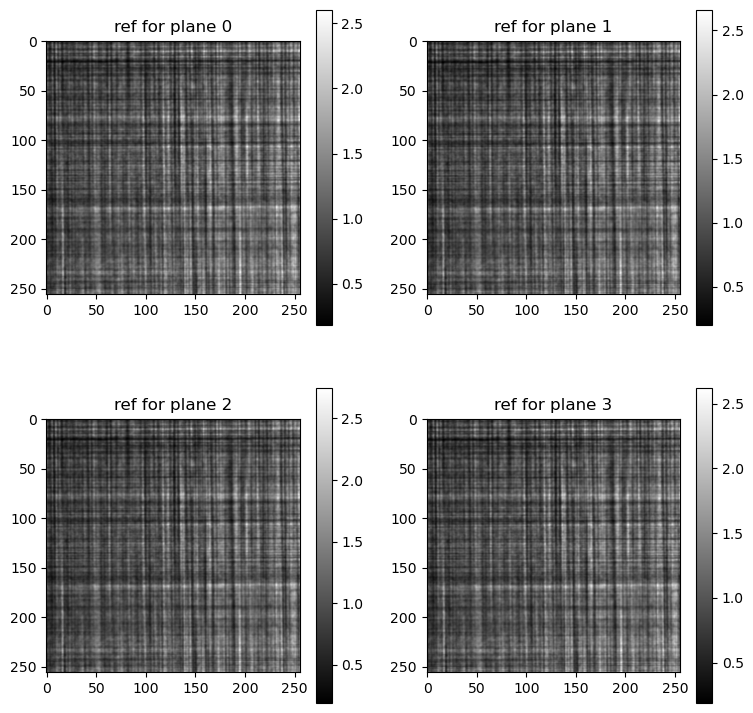

In [18]:
fig, axs = plt.subplots(2, 2, figsize=(9, 9))
im=axs[0,0].imshow(ref[0,0],cmap='gray')
axs[0,0].set_title('ref for plane 0')
fig.colorbar(im)
im=axs[0,1].imshow(ref[0,1],cmap='gray')
axs[0,1].set_title('ref for plane 1')
fig.colorbar(im)
im=axs[1,0].imshow(ref[0,2],cmap='gray')
axs[1,0].set_title('ref for plane 2')
fig.colorbar(im)
im=axs[1,1].imshow(ref[0,3],cmap='gray')
axs[1,1].set_title('ref for plane 3')
fig.colorbar(im)

# Save data, reference images, and shifts

In [19]:
for k in range(len(distances)):
    dxchange.write_tiff(data[:,k],f'data/data_3d_ald_{n}_{k}',overwrite=True)
for k in range(len(distances)):
    dxchange.write_tiff(ref[:,k],f'data/ref_3d_ald_{n}_{k}',overwrite=True)
np.save('data/shifts_sample',shifts_sample)
np.save('data/shifts_ref',shifts_ref)
np.save('data/shifts_ref0',shifts_ref0)

[[[-0.12371576  0.48472643]
  [ 0.46742654 -0.13068897]
  [-0.4207902   0.07765538]
  [ 0.04231757  0.46227312]]]
